In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime
 
import warnings
warnings.filterwarnings("ignore")

2023-08-25 09:21:13.772878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv('./data/EQIX_data.csv')
print(data.shape)
print(data.sample(7))

(1259, 7)
           date    open     high       low   close   volume  Name
358  2014-07-14  212.52  212.860  210.9300  211.16   627294  EQIX
838  2016-06-08  372.57  373.745  369.9900  372.94   598763  EQIX
815  2016-05-05  334.26  336.910  326.9500  330.89  1011560  EQIX
130  2013-08-15  169.83  169.990  163.7300  165.89  3329719  EQIX
592  2015-06-17  257.95  258.220  255.6900  257.12   794974  EQIX
378  2014-08-11  210.54  213.200  209.3125  211.37   720886  EQIX
23   2013-03-14  216.36  216.360  213.0100  215.05   485977  EQIX


In [3]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1259 non-null   datetime64[ns]
 1   open    1259 non-null   float64       
 2   high    1259 non-null   float64       
 3   low     1259 non-null   float64       
 4   close   1259 non-null   float64       
 5   volume  1259 non-null   int64         
 6   Name    1259 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 69.0+ KB


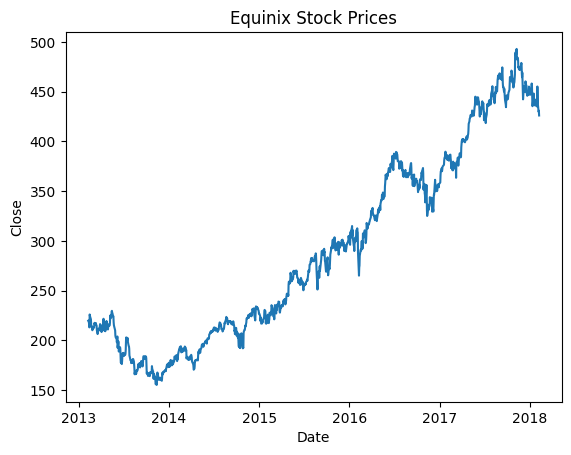

In [5]:
equinix = data[data['Name'] == 'EQIX']
prediction_range = equinix.loc[(equinix['date'] > datetime(2013,1,1))
 & (equinix['date']<datetime(2018,1,1))]
plt.plot(equinix['date'],equinix['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Equinix Stock Prices")
plt.show()

In [6]:
close_data = equinix.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1197


In [7]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
 
train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []
 
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x1292d3340>>

In [9]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10
36/36 [==============================] - 7s 81ms/step - loss: 0.0275
Epoch 2/10
36/36 [==============================] - 3s 70ms/step - loss: 0.0085
Epoch 3/10
36/36 [==============================] - 2s 63ms/step - loss: 0.0094
Epoch 4/10
36/36 [==============================] - 3s 93ms/step - loss: 0.0076
Epoch 5/10
36/36 [==============================] - 4s 103ms/step - loss: 0.0067
Epoch 6/10
36/36 [==============================] - 4s 100ms/step - loss: 0.0072
Epoch 7/10
36/36 [==============================] - 3s 95ms/step - loss: 0.0070
Epoch 8/10
36/36 [==============================] - 4s 108ms/step - loss: 0.0071
Epoch 9/10
36/36 [==============================] - 3s 75ms/step - loss: 0.0073
Epoch 10/10
36/36 [==============================] - 3s 83ms/step - loss: 0.0053


In [10]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
 
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
 
# predict the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluation metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 [==============================] - 1s 34ms/step
MSE 91.60002806140652
RMSE 9.570790357196552


In [ ]:
train = equinix[:training]
test = equinix[training:]
test['Predictions'] = predictions
 
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Equinix Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])